In [5]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import networkx as nx
import copy

try:
    os.makedirs(lattice_image_dir)
except:
    pass

from lfig import LatexFigure

In [2]:
sys.path.append("/home/bf16951/QMD")
import qmla

In [3]:
lattice_runs = [
    'Sep_30/22_40', # Ising 100 @ Ne=1000,Np=4000,
    'Oct_22/20_45',  # Heis w 1000/4000
    'Aug_19/22_42', # FH 18
    'Sep_29/11_40', # FH 93,
    'Oct_02/00_09' # FH 1000/4000, only a few results though  
]


all_runs_results = pd.DataFrame()
for lr in lattice_runs:
    lattice_record = pd.read_csv(os.path.join(
        '/home/bf16951/bc_results/', lr, 'combined_datasets', 'lattice_record.csv'
    ))
    
    all_runs_results = all_runs_results.append(lattice_record, ignore_index=True)

combined_lattice_record = pd.DataFrame(
    columns=['ModelType', 'Lattice', 'SuccessRate']
)

model_types = all_runs_results.model_type.unique()
lattice_types = all_runs_results.true_lattice.unique()
for m in model_types:
    for l in lattice_types:
        this_model_and_lattice = all_runs_results[
            (all_runs_results.true_lattice == l)
            & (all_runs_results.model_type == m)
        ]
        
        success_rate = this_model_and_lattice.true_model_found.sum() / len(this_model_and_lattice)        
        success_rate *= 100
        new_record = pd.Series(
            {
                'ModelType' : m, 
                'Lattice' : l,
                'SuccessRate' : success_rate, 
            }
        )
        combined_lattice_record.loc[len(combined_lattice_record)] = new_record 

count_number_instances_by_type = {
    mod : {
        lat : len(all_runs_results[
            (all_runs_results.model_type == mod)
            & (all_runs_results.true_lattice == lat)
            ])
        for lat in all_runs_results.true_lattice.unique()
    }
    for mod in all_runs_results.model_type.unique()
}        
    

/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


# Plots

# Generate lattice images

In [136]:
def draw_lattice_via_lf(
    coordinates, 
    connections, 
    fraction=1, 
    save_files=None, 
#     save_to_file=None
):
    plt.clf()
    lf = LatexFigure(fraction=fraction)
    ax = lf.new_axis(auto_label=False)
    
    Graph = nx.Graph()

    for c in coordinates:
        Graph.add_node(c)
        Graph.nodes[c]['position'] = tuple(coordinates[c])
        Graph.nodes[c]['label'] = str(c)

    # Get positions and labels
    positions = dict(
        zip(
            Graph.nodes(),
            tuple([prop['position']
                   for (n, prop) in Graph.nodes(data=True)])
        )
    )
    label_positions = []
    label_padding = 0.0
    labels = dict(
        zip(
            Graph.nodes(),
            tuple([prop['label'] for (n, prop) in Graph.nodes(data=True)])
        )
    )
    for key in positions.keys():
        label_positions.append(
            tuple(
                np.array(positions[key]) - np.array([0., label_padding])
            )
        )

    label_positions = dict(
        zip(
            positions.keys(),
            tuple(label_positions)
        )
    )

    # which nodes to connect (nearest neighbours)
    edges = []
    for c in coordinates:
        # neighbours = self.nearest_neighbours[c]
        neighbours = connections[c]
        for n in neighbours:
            edge = tuple(sorted([c, n]))
            if edge not in edges:
                edges.append(edge)

    plt.gca().invert_yaxis()  # so branch 0 on top
    nx.draw_networkx_nodes(
        Graph,
        with_labels=True,  # labels=labels,
        pos=positions,
        node_size=500*fraction,
        node_color='blue',
        ax = ax,
#         alpha=0.5
    )

    nx.draw_networkx_edges(
        Graph,
        pos=coordinates,
        edgelist=edges,
        edge_color='black',
        alpha=1,
        width = 10*fraction, 
#         style='dashed',
        label='Nearest neighbours', 
        ax = ax
    )

    ax.axis('off')
    for save_to_file in save_files:
#     if save_to_file is not None: 
        lf.save(save_to_file, quality=95)

In [139]:
paper_lattice_dir = "/home/bf16951/theory_paper/figure_development/lattices"
thesis_lattice_dir = os.path.abspath(
    "/home/bf16951/thesis/theoretical_study/lattices"
)
lattice_image_dir = os.path.join(
    os.getcwd(), 'lattices'
)
%matplotlib inline

avail_lattice_names = [
    '_2_site_chain', 
    '_3_site_chain', 
    '_4_site_chain', 
    '_5_site_chain', 
    '_6_site_chain', 
    '_3_site_lattice_fully_connected', 
    '_4_site_lattice_fully_connected',
    '_5_site_lattice_fully_connected',
    '_4_site_square',
    '_6_site_grid'
]
image_format = 'jpg'
lf_fraction = 0.2
for lattice_name in avail_lattice_names:

    lattice = copy.deepcopy(qmla.shared_functionality.topology_predefined.__getattribute__(lattice_name))
    coordinates = lattice.coordinates
    connections = lattice.site_connections

    save_files = [
        os.path.join(thesis_lattice_dir, "{}.{}".format(lattice_name, image_format)),
        os.path.join(paper_lattice_dir, "{}.{}".format(lattice_name, image_format))
    ]
    draw_lattice_via_lf(
        coordinates, 
        connections, 
        fraction = lf_fraction,
        save_files = save_files, 
#         save_to_file=save_file
    )

    
# Specific changes to some lattices 
# 3 sites -> make triangle
lattice_name = '_3_site_lattice_fully_connected'
lattice = copy.deepcopy(qmla.shared_functionality.topology_predefined.__getattribute__(lattice_name))
coordinates = lattice.coordinates
connections = lattice.site_connections

## Change specific nodes' coordinates for visual, e.g. make 3 sites into triangle
coordinates[2] = [1.5, 2]

save_files = [
    os.path.join(thesis_lattice_dir, "{}.{}".format(lattice_name, image_format)),
    os.path.join(paper_lattice_dir, "{}.{}".format(lattice_name, image_format))
]

draw_lattice_via_lf(
    coordinates, 
    connections, 
    fraction = lf_fraction,
    save_files = save_files
#     save_to_file=save_file
)

# 5 sites -> make pentagon
lattice_name = '_5_site_lattice_fully_connected'
lattice = copy.deepcopy(qmla.shared_functionality.topology_predefined.__getattribute__(lattice_name))
coordinates = lattice.coordinates
connections = lattice.site_connections

# Change specific nodes' coordinates for visual, e.g. make 3 sites into triangle
coordinates[5] = [1.5, 1.25]

save_files = [
    os.path.join(thesis_lattice_dir, "{}.{}".format(lattice_name, image_format)),
    os.path.join(paper_lattice_dir, "{}.{}".format(lattice_name, image_format))
]
draw_lattice_via_lf(
    coordinates, 
    connections, 
    fraction = lf_fraction,
    save_files = save_files, 
#     save_to_file=save_file
)  

/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommo

<Figure size 432x288 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

<Figure size 138.37x85.5174 with 0 Axes>

# Bar plot with results

In [140]:
all_lattice_types = [
    '_2_site_chain', 
    '_3_site_chain',
    '_3_site_lattice_fully_connected', 
    '_4_site_lattice_fully_connected',
    '_4_site_square',
    # the following are not considered by FH
    '_4_site_chain',
    '_5_site_chain', 
    '_6_site_chain', 
    '_5_site_lattice_fully_connected', 
    '_6_site_grid'
]

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def offset_image(coord, name, ax, lattice_image_dir, img_format, lattice_idx = 1, zoom=0.4):
    path = os.path.join(lattice_image_dir, "{}.{}".format(name, img_format))
    img = plt.imread(path)    
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im, 
        coord, 
        xybox=(0, 0), 
        frameon=False,
        xycoords='data',  
        boxcoords="offset points", 
        pad=0
    )

    ax.add_artist(ab)
    idx = chr(ord('`')+ ( lattice_idx) )

    loc = ( coord[0] - 30, coord[1])
    ax.annotate(
        r"\textbf{{({})}}".format(idx),
        xy = loc,
    )
    

def bar_plot_model_types_success_rates(
    combined_lattice_record, 
    lattice_names,
    ax,
    lattice_image_dir,
    legend=True, 
    lattice_img_x_pos=-10,
    image_format='png', 
    zoom=1, 
    save_to_file=None, 
):
    offset = 0.25
    # Ising
    y_positions = [y-offset for y in range(len(lattice_names))]
    scores = [
        combined_lattice_record[
            (combined_lattice_record.ModelType == 'IsingLatticeSet')
            & (combined_lattice_record.Lattice == l)
        ].SuccessRate.sum()
        for l in lattice_names
    ]

    ax.barh(
        y_positions, 
        scores, 
        height = 0.3, 
        label = "Ising",
        color = ising_colour
    )

    # Heisenberg
    y_positions = [y for y in range(len(lattice_names))]
    scores = [
        combined_lattice_record[
            (combined_lattice_record.ModelType == 'HeisenbergLatticeSet')
            & (combined_lattice_record.Lattice == l)
        ].SuccessRate.sum()
        for l in lattice_names
    ]


    ax.barh(
        y_positions, 
        scores, 
        height = 0.25, 
        label = "Heisenberg",
        color = heis_colour
    )

    # Fermi Hubbard
    y_positions = [y+offset for y in range(len(lattice_names))]
    scores = [
        combined_lattice_record[
            (combined_lattice_record.ModelType == 'FermiHubbardLatticeSet')
            & (combined_lattice_record.Lattice == l)
        ].SuccessRate.sum()
        for l in lattice_names
    ]

    ax.barh(
        y_positions, 
        scores, 
        height = 0.25, 
        label = "Hubbard",
        color = hubbard_colour
    )


    ax.set_yticks(range(len(lattice_names)))
    ax.set_yticklabels([])

    # ax.tick_params(axis='y', which='major', pad=26)
    ax.tick_params(
        axis='y', 
        which='major',
        left=False
    )
    ax.tick_params(
        axis='both', 
#         labelsize=axis_fontsize,
        pad = 10
    )

    max_score_to_show = int(round( (3+combined_lattice_record.SuccessRate.max()) / 0.05) * 0.05)
    ax.set_xlim( lattice_img_x_pos-35 , max_score_to_show )
    ax.set_xticks(
        [0, 50, 100]
    #         [0,25, 50, 75, 100]
    )
    ax.xaxis.set_major_formatter(PercentFormatter(100))       

    for y_coord, l in enumerate(lattice_names):
        coord = (lattice_img_x_pos, y_coord)
        lattice_idx = all_lattice_types.index(l) + 1
        print("{} has idx {}".format(l, lattice_idx))
        offset_image(
            coord = coord, 
            name = l, 
            ax = ax, 
            zoom=zoom, 
            lattice_image_dir = lattice_image_dir,
            img_format=image_format,
            lattice_idx = lattice_idx
        )

    plt.gca().invert_yaxis()
    if legend:
        ylim = ax.get_ylim()
        ax.set_ylim( ylim[0], ylim[1]-0.75, )
        ax.legend(
            ncol=3,
            loc = 'upper center'
        )

_2_site_chain has idx 1
_3_site_chain has idx 2
_3_site_lattice_fully_connected has idx 3
_4_site_lattice_fully_connected has idx 4
_4_site_square has idx 5
_4_site_chain has idx 6
_5_site_chain has idx 7
_6_site_chain has idx 8
_5_site_lattice_fully_connected has idx 9
_6_site_grid has idx 10


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


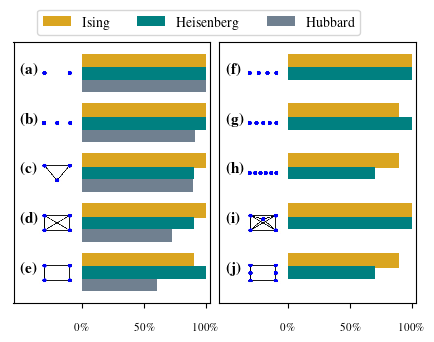

In [166]:
# Two columns
    
is_heis_fh_lattice_types = [
    '_2_site_chain', 
    '_3_site_chain',
    '_3_site_lattice_fully_connected', 
    '_4_site_lattice_fully_connected',
    '_4_site_square',
]
is_heis_lattice_types = [
# the following are not considered by FH
    '_4_site_chain',
    '_5_site_chain', 
    '_6_site_chain', 
    '_5_site_lattice_fully_connected', 
    '_6_site_grid'
]

lf = LatexFigure(
    fraction=0.75, 
    gridspec_layout = (2, 2),
    gridspec_params  = {
        'wspace' : 0.05
    }
)
ax_left = lf.new_axis(
    auto_label=False,
    span=(2,1)
)
ax_right = lf.new_axis(
    auto_label=False,
    span=(2,1)
)

ising_colour = 'goldenrod'
heis_colour = 'teal'
hubbard_colour = 'slategray'


zoom=0.2
bar_plot_model_types_success_rates(
    lattice_names = is_heis_fh_lattice_types, 
    combined_lattice_record = combined_lattice_record, 
    ax = ax_left,
    lattice_image_dir = lattice_image_dir, 
    image_format=image_format,
    lattice_img_x_pos = -20, 
    zoom=zoom, 
    legend=False, 
)

ax_left.legend(
    ncol=3,
    bbox_to_anchor=(1.8, 1.15)
)

bar_plot_model_types_success_rates(
    lattice_names = is_heis_lattice_types, 
    combined_lattice_record = combined_lattice_record, 
    lattice_img_x_pos = -20, 
    lattice_image_dir = lattice_image_dir,
    image_format=image_format,
    zoom=zoom, 
    legend=False, 
    ax = ax_right ,
)
ax_left.invert_yaxis()
ax_right.invert_yaxis()
lf.save(
    os.path.join(
        paper_lattice_dir, 
        "lattice_successes_two_column_half_width.pdf"
    ),
)
lf.save(
    os.path.join(
        thesis_lattice_dir, 
        "lattice_successes_two_column_half_width.pdf"
    ),
)


